In [17]:
import numpy as np
import codecs
import argparse
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from nltk import Tree
import random
import math
import subprocess
import sys
from collections import deque, Counter, defaultdict
from scipy.sparse.csgraph import minimum_spanning_tree
import string

from tools import dependency, sentence_attentions
from tqdm import tqdm

%matplotlib inline

In [18]:
selected_model = 'fr-cased'
if selected_model == 'dev':
    attention_file = '../BertAA/BertAA-dev/attentions.npz'
    token_file = '../BertAA/BertAA-dev/source.txt'
    conllu_file_name = '../graph-extraction/endev.conllu'
    no_softmax = False
elif selected_model == 'test':
    attention_file = '../BertAA/attentions.npz'
    token_file = '../BertAA/source.txt'
    conllu_file_name = '../data/entest.conllu'
    no_softmax = True
    
elif selected_model == 'fr-cased':
    attention_file = '../BertAA/BertAA-ml-fr-cased/attentions.npz'
    token_file = '../BertAA/BertAA-ml-fr-cased/source.txt'
    conllu_file_name = '../graph-extraction/frdev.conllu'
    no_softmax = False
    

In [9]:

maxlen = 1000

fontsize=8

#this is necessary in this case
eos =True

dependency_rels = dependency.read_conllu(conllu_file_name,True)

with open(token_file) as tokens_file:
    tokens_loaded = [l.split() for l in tokens_file]
    
attentions_loaded = np.load(attention_file)
sentences_count = 1000
layers_count = attentions_loaded['arr_0'].shape[0]
heads_count = attentions_loaded['arr_0'].shape[1]

token_ids_grouped, words_lists = dependency.group_wordpieces(tokens_loaded, conllu_file_name)



In [21]:
sentences = None
attention_gen = sentence_attentions.generate_matrices(attentions_loaded, token_ids_grouped, eos, no_softmax, maxlen,sentences)
#attention_gen = enumerate(attention_gen)

viss = {sentence_idx: att_mts for att_mts, sentence_idx in tqdm(attention_gen)}

42it [00:20,  2.06it/s]Token mismatch sentence skipped 42
825it [07:01,  2.21it/s]Token mismatch sentence skipped 826
998it [08:28,  1.96it/s]


In [22]:
def plot_head(viss,words_lists, l, h, dep_rels=None,rel_type=None):
    if dep_rels and rel_type:
        probs = np.array([len(dep_rels[i][rel_type])/len(words_lists[i])**2 for i in viss.keys()])
        probs /= probs.sum()
    choices = np.random.choice(list(viss.keys()), 9,replace=False, p=probs)
    fig, axes = plt.subplots(3,3,figsize=(18,18))
    for  ch, ax in zip(choices, axes.ravel()):
        matrix = np.array(viss[ch])
        if type(l) == list or type(h) == list:
            assert len(l) == len(h)
            matrix = np.average(matrix[l,h,:,:], axis=0)
        else:
            matrix = matrix[l,h,:,:]

        im = ax.imshow(matrix,cmap='Blues')
        
        if dep_rels and rel_type:
            for i, j in dep_rels[ch][rel_type]:
                ax.text(j, i, "X", ha="center", va="center", color="red")
        ax.set_title(ch)
        ax.set_xticks(np.arange(len(words_lists[ch])))
        ax.set_yticks(np.arange(len(words_lists[ch])))
        ax.set_xticklabels(words_lists[ch], rotation=90)
        ax.set_yticklabels(words_lists[ch])
    plt.show()


## Best subject p2d (dev: 70.4%, test: 68.6%)
### Copula rearanged (dev : 75.4%,  test: 73.8%)

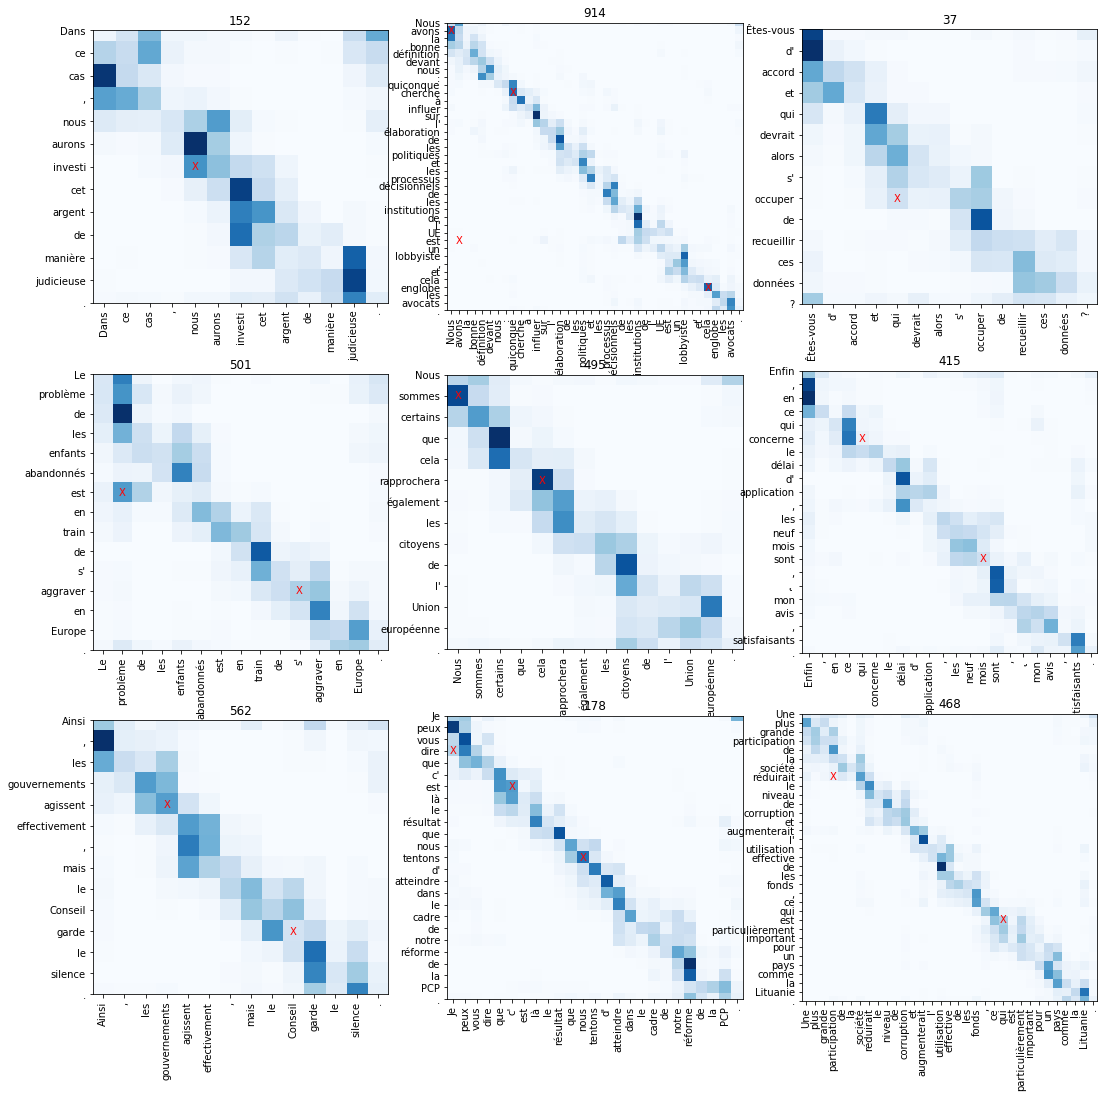

In [36]:
plot_head(viss,words_lists, [5], [ 4], dependency_rels, 'subject-p2d')

## Evaluate syntactic alignment

In [24]:
def average_heads(all_matrices, ls, hs):
    return np.average(all_matrices[ls,hs,:,:], axis=0)

def uas_from_matrices(matrices, dep_rels):
    retrived = defaultdict(int)
    total = defaultdict(int)
    for matrix, dep_rel in zip(matrices, dep_rels):
        retr_pairs = set(zip(range(matrix.shape[0]), np.argmax(matrix, axis=1)))
        for rel_type, rel_pairs in dep_rel.items():
            retrived[rel_type] += len(set(rel_pairs).intersection(retr_pairs) )
            total[rel_type] += len(set(rel_pairs))
    
    for k in sorted(retrived.keys()):
        if total[k] > 0:
            print(f"UAS for {k} : {retrived[k]/total[k]} (number of relations: {total[k]})")
        else:
            print(f"No relations for {k}")

In [35]:
len(viss)

998

In [34]:
gen = (average_heads(np.array(all_ms),[5], [4]) for all_ms in viss.values())
uas_from_matrices(gen, dependency_rels)


UAS for adj-clause-d2p : 0.16196136701337296 (number of relations: 673)
UAS for adj-clause-p2d : 0.017830609212481426 (number of relations: 673)
UAS for adj-modifier-d2p : 0.1998936735778841 (number of relations: 1881)
UAS for adj-modifier-p2d : 0.10579479000531632 (number of relations: 1881)
UAS for adv-clause-d2p : 0.010238907849829351 (number of relations: 293)
UAS for adv-clause-p2d : 0.0 (number of relations: 293)
UAS for adv-modifier-d2p : 0.1099554234769688 (number of relations: 1346)
UAS for adv-modifier-p2d : 0.15824665676077265 (number of relations: 1346)
UAS for all-d2p : 0.07243116185359301 (number of relations: 29780)
UAS for all-p2d : 0.13854936198791135 (number of relations: 29780)
UAS for apposition-d2p : 0.1626984126984127 (number of relations: 252)
UAS for apposition-p2d : 0.027777777777777776 (number of relations: 252)
UAS for auxiliary-d2p : 0.03761755485893417 (number of relations: 638)
UAS for auxiliary-p2d : 0.2507836990595611 (number of relations: 638)
UAS for c